In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import statsmodels.api as sm
import quandl
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Dollar turnover

Looks terrible as the data quality is poor


$$  \sum {\text{dvol}_t} $$



In [4]:
dvol=calculate_dollar_volume(cleansed)

tsmom_model.py:32: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='mean')
tsmom_model.py:34: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='sum')
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
tsmom_model.py:39: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

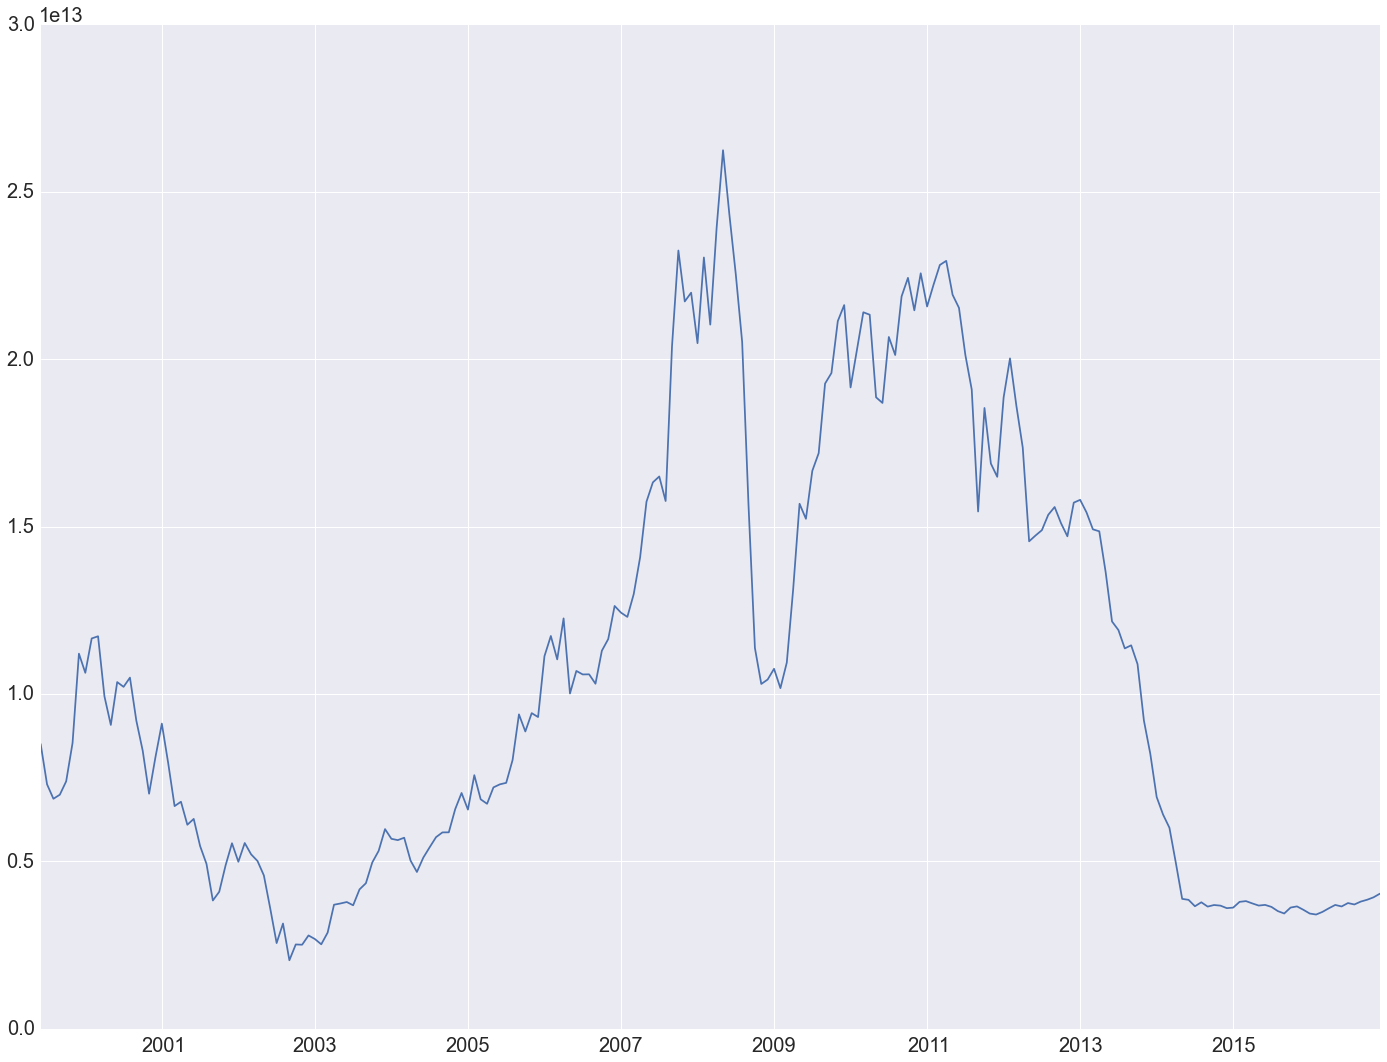

In [5]:
dvol.dropna(how='all').sum(axis=1).plot()

# Funding Rates

* TED spread

In [6]:
ted=quandl.get('FRED/TEDRATE').Value

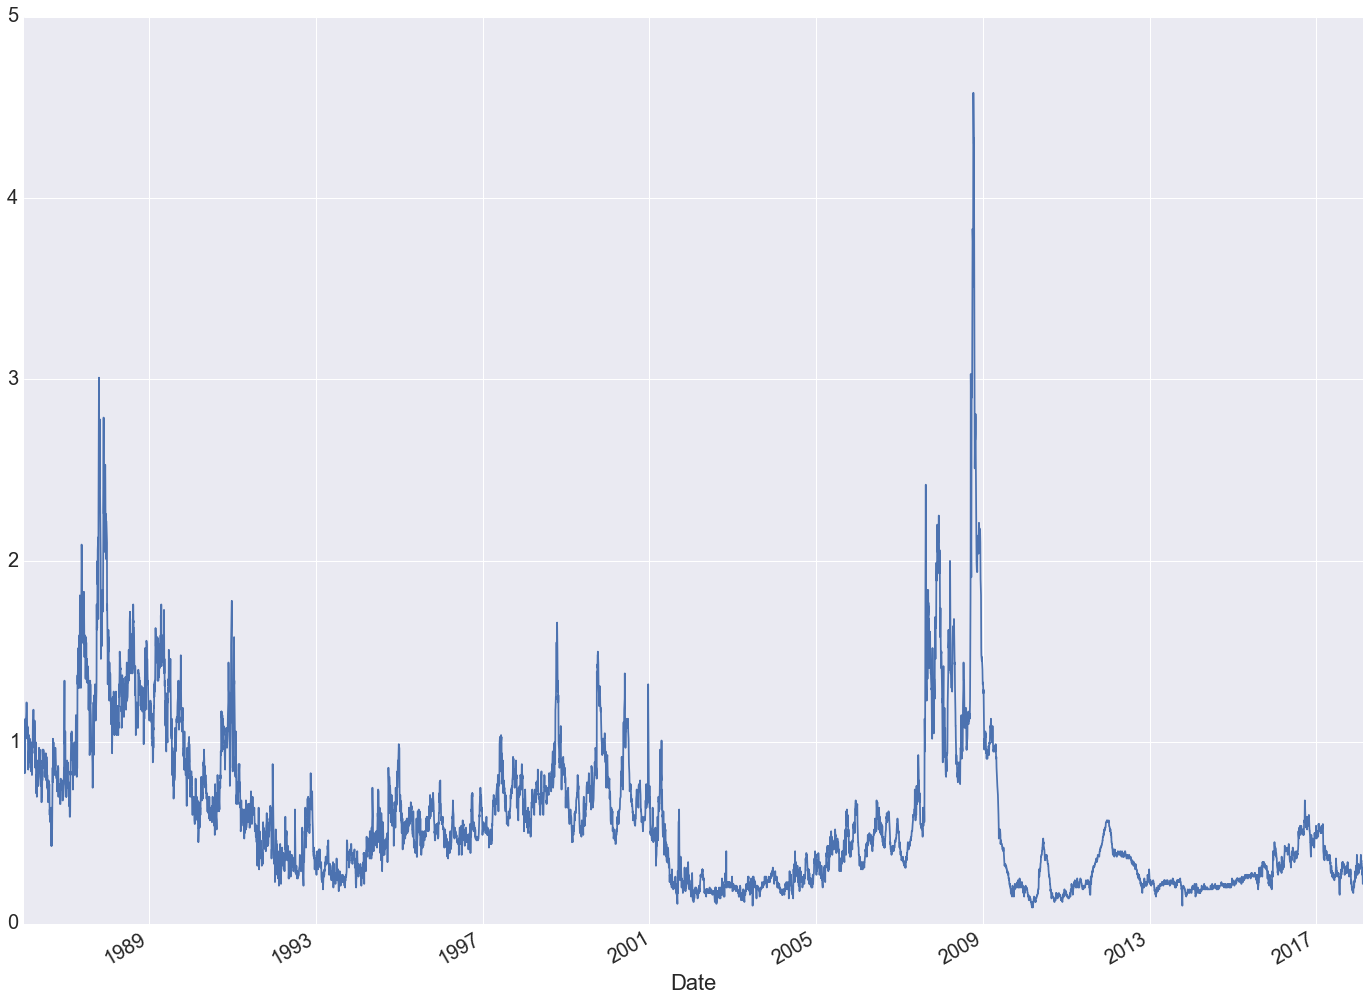

In [7]:
ted.plot()

# Swap versus cash financed

OIS - Tbills

* Missing OIS data

In [8]:
tbill=quandl.get('FRED/DTB3').Value

# Libor term repo

Overight - Repo rate

* Missing LIBOR O/N rate
* Ticker is FRED/USDONTDIS6N (or something similar)

In [9]:
libor=quandl.get('FRED/USDONTD156N').VALUE
repo=pd.read_csv('repo.csv',index_col=0,parse_dates=True)
# This needs to get replaced with 
libor_term_repo=(repo.TreasuryRepo-libor).dropna()

# On the run versus off the run 

In [10]:
us10y_zero=quandl.get('FED/SVENY').SVENY10.resample(rule='d',how='last').dropna()
yield10=quandl.get('USTREASURY/YIELD')['10 YR'].resample(rule='d',how='last').dropna()
on_off=(us10y_zero-yield10).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


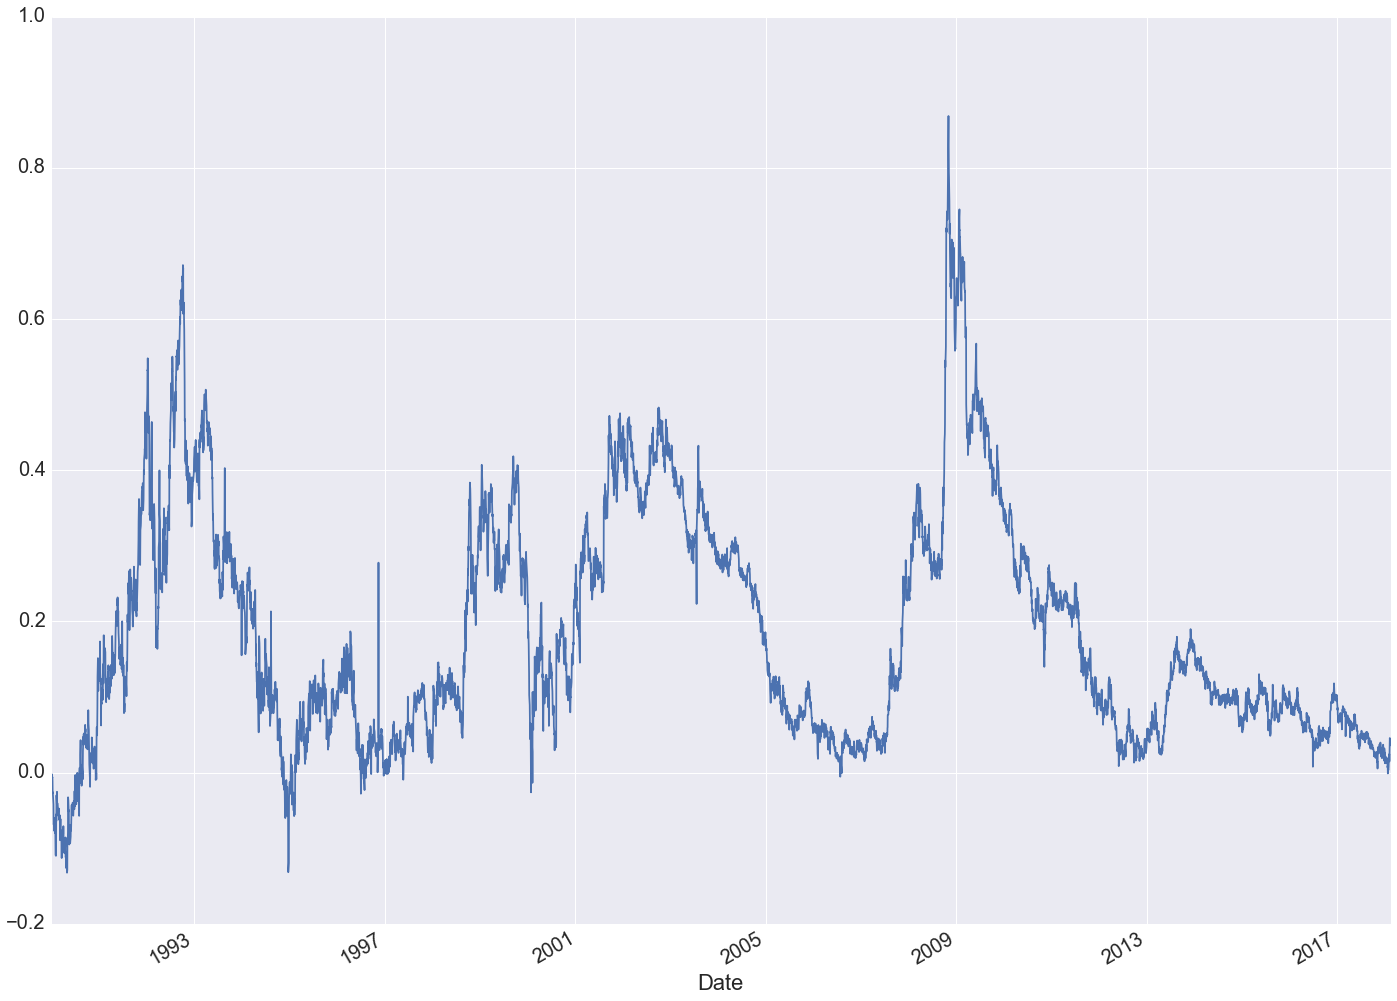

In [11]:
on_off.plot()

# Pastor and Stambagh  (2003)

https://faculty.chicagobooth.edu/lubos.pastor/research/liq_data_1962_2016.txt

In [12]:
PS=pd.read_csv('PS.csv',index_col=0,parse_dates=True).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


# Getting everything ready for regressions

In [13]:
funding_liquidity = pd.DataFrame()
market_liquidity = pd.DataFrame()
funding_liquidity['TED Spread']=ted.resample(rule='m',how='last')/100.
funding_liquidity['LIBOR term repo']=libor_term_repo.resample(rule='m',how='last')/100.


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


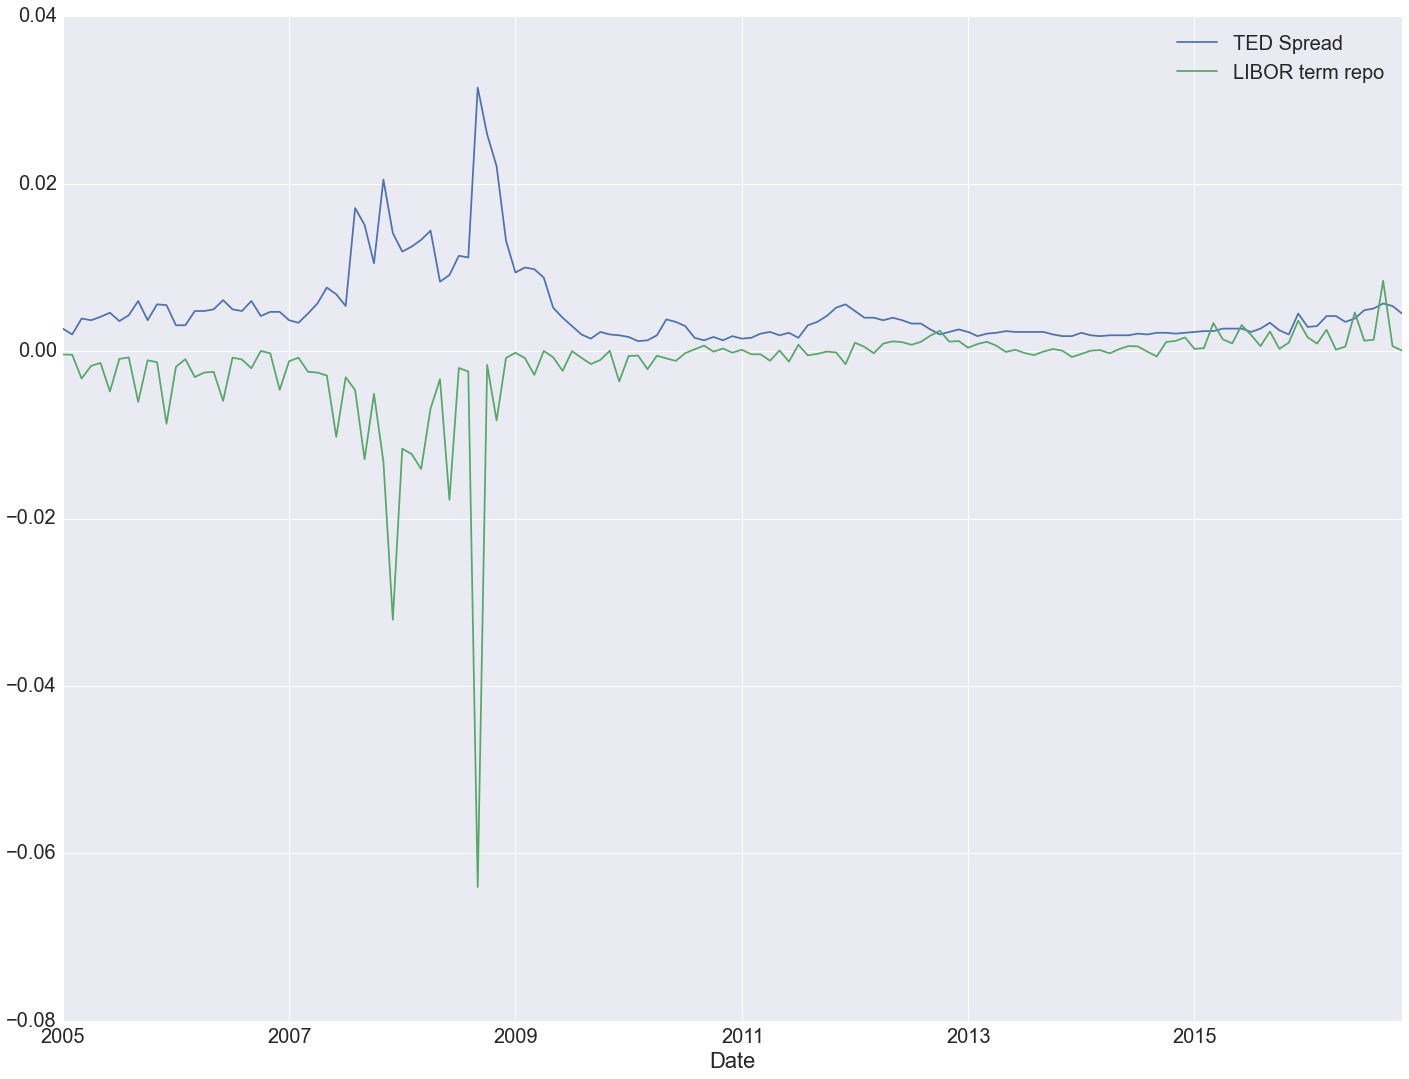

In [14]:
funding_liquidity.dropna().plot()

In [15]:
market_liquidity = pd.DataFrame()
market_liquidity['PS']=PS['Innovations in aggregate liquidity'].resample(rule='m',how='last')
market_liquidity['On versus off the run Treasuries']=on_off.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


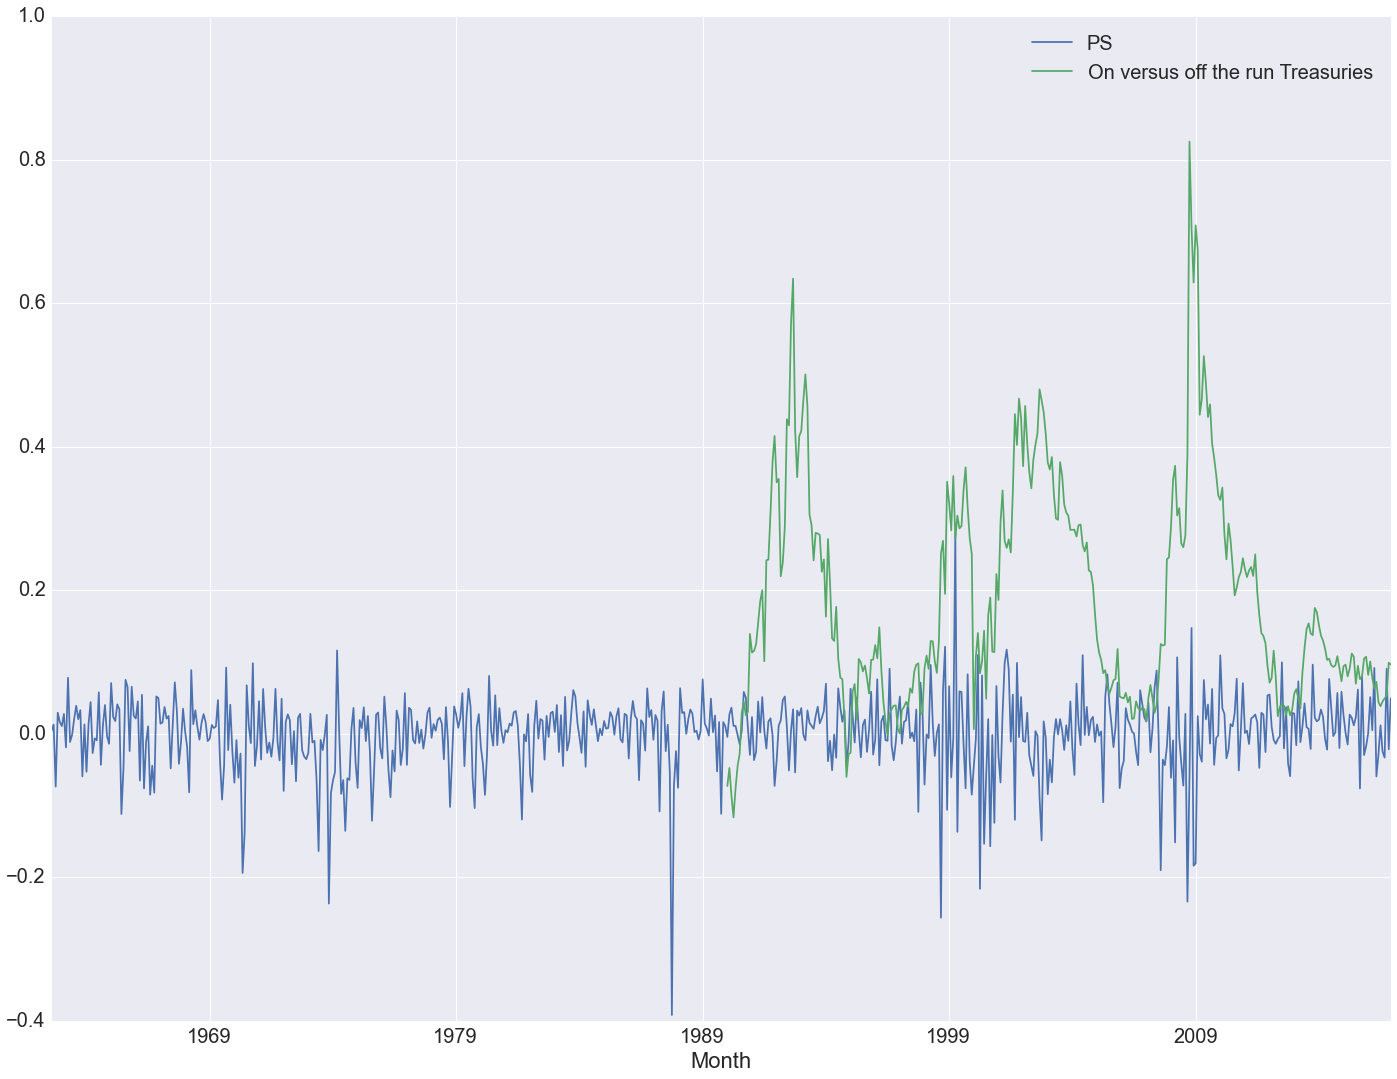

In [16]:
market_liquidity.plot()

# Determinents of Liquidity

In [17]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:43: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:45: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:47: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:47: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:50: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [18]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:259: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:259: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [19]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [20]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [21]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    sector_factor[s]=sector_PC[s][0]

# Market Liqudity for Amihud common factors across asset classes




In [32]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind=sector_factor[s].index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

# Funding Liqudity for Amihud common factors across asset classes

Note, since our repo data doesn't go back as long the we only look at it from 2005 to 2016



In [34]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [36]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,-7.89,-9.75,-7.52,-6.01
PSTstats,-2.02,-2.71,-2.11,-2.53
On versus off the run Treasuries,13.91,9.22,9.08,6.95
On versus off the run TreasuriesTstats,11.95,5.86,6.21,9.58
TED Spread,136.85,116.48,217.56,130.57
TED SpreadTstats,1.54,1.77,2.61,2.97
LIBOR term repo,-34.75,-43.18,-80.77,-61.07
LIBOR term repoTstats,-0.85,-1.94,-1.92,-2.77


In [37]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Commodities &  Equities &  Currencies &  Fixed Income \\
\midrule
PS                                     &        -7.89 &     -9.75 &       -7.52 &         -6.01 \\
PSTstats                               &        -2.02 &     -2.71 &       -2.11 &         -2.53 \\
On versus off the run Treasuries       &        13.91 &      9.22 &        9.08 &          6.95 \\
On versus off the run TreasuriesTstats &        11.95 &      5.86 &        6.21 &          9.58 \\
TED Spread                             &       136.85 &    116.48 &      217.56 &        130.57 \\
TED SpreadTstats                       &         1.54 &      1.77 &        2.61 &          2.97 \\
LIBOR term repo                        &       -34.75 &    -43.18 &      -80.77 &        -61.07 \\
LIBOR term repoTstats                  &        -0.85 &     -1.94 &       -1.92 &         -2.77 \\
\bottomrule
\end{tabular}



# Run for unanticipated shocks from residuals from AR(2)

In [38]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [39]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind=resid[s].index
        # Please make the fit robust 
        res=sm.OLS(resid[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [41]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [42]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,-0.65,-0.55,-0.00,0.51
PSTstats,-0.23,-0.15,-0.00,0.21
On versus off the run Treasuries,1.29,2.24,4.17,1.54
On versus off the run TreasuriesTstats,0.82,1.48,2.32,1.39
TED Spread,-112.43,-66.16,-30.17,-32.98
TED SpreadTstats,-2.21,-1.15,-0.66,-0.75
LIBOR term repo,74.65,62.30,26.92,51.54
LIBOR term repoTstats,4.43,3.72,3.71,6.04


In [43]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Commodities &  Equities &  Currencies &  Fixed Income \\
\midrule
PS                                     &        -0.65 &     -0.55 &       -0.00 &          0.51 \\
PSTstats                               &        -0.23 &     -0.15 &       -0.00 &          0.21 \\
On versus off the run Treasuries       &         1.29 &      2.24 &        4.17 &          1.54 \\
On versus off the run TreasuriesTstats &         0.82 &      1.48 &        2.32 &          1.39 \\
TED Spread                             &      -112.43 &    -66.16 &      -30.17 &        -32.98 \\
TED SpreadTstats                       &        -2.21 &     -1.15 &       -0.66 &         -0.75 \\
LIBOR term repo                        &        74.65 &     62.30 &       26.92 &         51.54 \\
LIBOR term repoTstats                  &         4.43 &      3.72 &        3.71 &          6.04 \\
\bottomrule
\end{tabular}



# FHT method

In [44]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:269: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:270: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:271: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:271: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [45]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [46]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [47]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [48]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    sector_factor[s]=sector_PC[s][0]

# Market liquidity
TODO: Make errors robus

In [49]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [50]:
results_df.T.round(2)

,0,1,2,3
PS,10.55,16.73,6.17,-8.90
PSTstats,2.35,3.08,2.49,-2.50
On versus off the run Treasuries,-6.84,-8.71,-5.67,6.70
On versus off the run TreasuriesTstats,-3.04,-3.19,-4.19,6.53


In [51]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [52]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,10.55,16.73,6.17,-8.90
PSTstats,2.35,3.08,2.49,-2.50
On versus off the run Treasuries,-6.84,-8.71,-5.67,6.70
On versus off the run TreasuriesTstats,-3.04,-3.19,-4.19,6.53
TED Spread,-427.06,-538.33,-241.85,315.40
TED SpreadTstats,-4.26,-5.13,-4.27,6.50
LIBOR term repo,232.03,239.80,125.01,-208.16
LIBOR term repoTstats,4.44,5.73,7.47,-7.38


In [53]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Commodities &  Equities &  Currencies &  Fixed Income \\
\midrule
PS                                     &        10.55 &     16.73 &        6.17 &         -8.90 \\
PSTstats                               &         2.35 &      3.08 &        2.49 &         -2.50 \\
On versus off the run Treasuries       &        -6.84 &     -8.71 &       -5.67 &          6.70 \\
On versus off the run TreasuriesTstats &        -3.04 &     -3.19 &       -4.19 &          6.53 \\
TED Spread                             &      -427.06 &   -538.33 &     -241.85 &        315.40 \\
TED SpreadTstats                       &        -4.26 &     -5.13 &       -4.27 &          6.50 \\
LIBOR term repo                        &       232.03 &    239.80 &      125.01 &       -208.16 \\
LIBOR term repoTstats                  &         4.44 &      5.73 &        7.47 &         -7.38 \\
\bottomrule
\end{tabular}



# Run for unanticipated shocks from residuals from AR(2)


In [61]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [62]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [63]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [64]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,-0.03,-0.16,4.29,3.36
PSTstats,-0.01,-0.06,0.68,1.28
On versus off the run Treasuries,-3.02,-2.82,-6.26,2.57
On versus off the run TreasuriesTstats,-1.67,-2.44,-2.44,2.20
TED Spread,-81.48,-5.13,-171.35,48.34
TED SpreadTstats,-0.81,-0.09,-1.38,0.77
LIBOR term repo,-55.96,-28.12,7.95,17.43
LIBOR term repoTstats,-1.24,-0.84,0.17,0.54


In [65]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Commodities &  Equities &  Currencies &  Fixed Income \\
\midrule
PS                                     &        -0.03 &     -0.16 &        4.29 &          3.36 \\
PSTstats                               &        -0.01 &     -0.06 &        0.68 &          1.28 \\
On versus off the run Treasuries       &        -3.02 &     -2.82 &       -6.26 &          2.57 \\
On versus off the run TreasuriesTstats &        -1.67 &     -2.44 &       -2.44 &          2.20 \\
TED Spread                             &       -81.48 &     -5.13 &     -171.35 &         48.34 \\
TED SpreadTstats                       &        -0.81 &     -0.09 &       -1.38 &          0.77 \\
LIBOR term repo                        &       -55.96 &    -28.12 &        7.95 &         17.43 \\
LIBOR term repoTstats                  &        -1.24 &     -0.84 &        0.17 &          0.54 \\
\bottomrule
\end{tabular}

